In [1]:
from visual_transformer import *

In [2]:
device = torch.device('cuda:0')

In [3]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1070


In [4]:
from game import *

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
game_settings = BIG_tool_use_advanced_2_5
game_settings.gameSize = 224 # for compatibility with brain's expected size
G = discreteGame(game_settings)

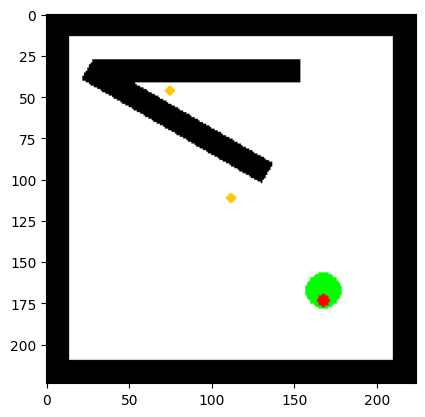

In [6]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [17]:
bare1_settings = G.random_bare_settings(gameSize=224, max_agent_offset=0.5)

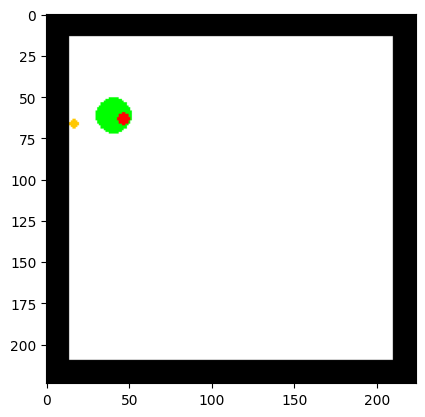

In [18]:
G2 = discreteGame(bare1_settings)
plt.imshow(G2.getData())

In [20]:
bare1_settings.agent_x

0.27750298519538896

In [21]:
bare1_settings.agent_y

0.18533136250653828

In [22]:
bare1_settings.gold[0]

(0.3014335596355257, 0.07864551400425951)

In [7]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [8]:
vocab_size = 10000
# tokenizer.save_model(".", "tokenizer/eng_sentences_tokenizer_vc10000")
tokenizer = ByteLevelBPETokenizer(
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-vocab.json",
    "./text_pretraining_tokenizer/eng_sentences_tokenizer_vc10000_v2-merges.txt",
)   
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)   
tokenizer.enable_truncation(max_length=32)
tokenizer.enable_padding()

In [9]:
# Setup for the 'control' tasks, to prevent drift

In [10]:
## Dataset
class SampleDataset(Dataset):
    def __init__(self, seq_length = 32, evaluate: bool = False, tokenizer=None, device = None):
        if device is None:
            device = 'cpu'
        self.device = device
        self.seq_length = seq_length
        if tokenizer is None:
            tokenizer = ByteLevelBPETokenizer(
                "./text_pretraining_tokenizer/eng_sentences_tokenizer_v2-vocab.json",
                "./text_pretraining_tokenizer/eng_sentences_tokenizer_v2-merges.txt",
            )   
        tokenizer._tokenizer.post_processor = BertProcessing(
            ("</s>", tokenizer.token_to_id("</s>")),
            ("<s>", tokenizer.token_to_id("<s>")),
        )   
        tokenizer.enable_truncation(max_length=self.seq_length)
        tokenizer.enable_padding()#length=seq_length)
        # or use the RobertaTokenizer from `transformers` directly.

        self.examples = []

        src_files = Path("./text_pretraining_data/").glob("*-eval.txt") if evaluate else Path("./text_pretraining_data/").glob("*-train.txt")
        for src_file in src_files:
            print("🔥", src_file)
            lines = src_file.read_text(encoding="utf-8").splitlines()
            self.examples += [x.ids for x in tokenizer.encode_batch(lines)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i): 
        # We’ll pad at the batch level.
        return torch.tensor(self.examples[i]).to(self.device)

In [11]:
sdt = SampleDataset(tokenizer=tokenizer)
sdv = SampleDataset(tokenizer=tokenizer, evaluate=True)

🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


In [12]:
ent_criterion = nn.CrossEntropyLoss(ignore_index=0)

def get_text_loss(res, inputs):
    return torch.sum(ent_criterion(res[:, :, :-1], inputs[:, 1:]))

In [13]:
# Ok, setup for the tutorial itself

In [14]:
# Left-right (interchangeable)
task2_prompts_lrgold = [ \
    "Is the gold to the left or to the right of you?", \
    "Which side is it on?", \
    "Is it to the left or right of the agent?", \
    "Do you need to go left or right to get the gold?", \
    "Please tell me whether the gold is left or right.", \
    "Please tell me which side is the gold on.", \
    "Which side to you need to go to get it?", \
    "Which side has gold?", \
    "On which side is the gold?"
]

task2_Lreplies_lrgold = [ \
    "Left", \
    "It's to the left.", \
    "It's on the left.", \
    "Go left."
]

task2_Rreplies_lrgold = [ \
    "Right", \
    "It's to the right.", \
    "It's on the right.", \
    "Go right."
]

task2_prompts_udgold = [ \
    "Is the gold above or below you?", \
    "Is it up or down from the agent?", \
    "Do you need to go up or down to get the gold?", \
    "Please tell me whether the gold is above or below you.", \
    "Please tell me whether the gold is up or down.", \
    "Do you need to go up or down to get it?", \
    "Which side has gold?", \
    "On which side is the gold?"
]

task2_Ureplies_udgold = [ \
    "Up", \
    "Above", \
    "It's up.", \
    "It's above me.", \
    "Go up."
]

task2_Dreplies_udgold = [ \
    "Down", \
    "Below", \
    "It's down.", \
    "It's below me.", \
    "Go down."
]

task2_prompts_lragent = [ \
    "Are you to the left or right of the gold?", \
    "Which side is the gold on?", \
    "Is the agent to the left or right of the gold?", \
    "Please tell me whether you are right or left of the gold.", \
    "Please tell me which side you are relative to the gold.", \
    "On which side of the gold are you?"
]

task2_Lreplies_lragent = [ \
    "Left", \
    "I'm to the left.", \
    "The agent is on the left."
]

task2_Rreplies_lragent = [ \
    "Right", \
    "I'm to the right.", \
    "The agent is on the right."
]

task2_prompts_udagent = [ \
    "Are you to the left or right of the gold?", \
    "Which side is the gold on?", \
    "Is the agent to the left or right of the gold?", \
    "Please tell me whether you are right or left of the gold.", \
    "Please tell me which side you are relative to the gold.", \
    "On which side of the gold are you?"
]

task2_Ureplies_udagent = [ \
    "Up", \
    "I'm above it.", \
    "The agent is above the gold."
]

task2_Dreplies_udagent = [ \
    "Down", \
    "I'm below it.", \
    "The agent is below the gold."
]

In [15]:
task2_prompts_lrgold_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_prompts_lrgold)]).contiguous().to(device)
task2_Lreplies_lrgold_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Lreplies_lrgold)]).contiguous().to(device)
task2_Rreplies_lrgold_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Rreplies_lrgold)]).contiguous().to(device)

task2_prompts_udgold_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_prompts_udgold)]).contiguous().to(device)
task2_Ureplies_udgold_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Ureplies_udgold)]).contiguous().to(device)
task2_Dreplies_udgold_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Dreplies_udgold)]).contiguous().to(device)

task2_prompts_lragent_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_prompts_lragent)]).contiguous().to(device)
task2_Lreplies_lragent_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Lreplies_lragent)]).contiguous().to(device)
task2_Rreplies_lragent_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Rreplies_lragent)]).contiguous().to(device)

task2_prompts_udagent_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_prompts_udagent)]).contiguous().to(device)
task2_Ureplies_udagent_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Ureplies_udagent)]).contiguous().to(device)
task2_Dreplies_udagent_tensor = torch.tensor([x.ids for x in tokenizer.encode_batch(task2_Dreplies_udagent)]).contiguous().to(device)

In [33]:
def get_lens(prompt_tensor):
    lens = []
    max_len = prompt_tensor.size()[1]
    for prompt in prompt_tensor:
        for ending in range(max_len):
            if prompt[ending] == 2:
                lens.append(ending)
                break
    return lens

In [35]:
task2_prompts_lrgold_lens = get_lens(task2_prompts_lrgold_tensor)
task2_prompts_udgold_lens = get_lens(task2_prompts_udgold_tensor)
task2_prompts_lragent_lens = get_lens(task2_prompts_lragent_tensor)
task2_prompts_udagent_lens = get_lens(task2_prompts_udagent_tensor)


In [31]:
task2_Rreplies_lrgold_tensor.size()

torch.Size([4, 8])

In [32]:
task2_prompts_lrgold_tensor

tensor([[   0,  783,  275, 3118,  271,  275,  840,  591,  271,  275,  724,  317,
          296,   35,    2],
        [   0, 2130, 1917,  307,  360,  338,   35,    2,    0,    0,    0,    0,
            0,    0,    0],
        [   0,  783,  360,  271,  275,  840,  591,  724,  317,  275, 7407,   35,
            2,    0,    0],
        [   0,  527,  296,  453,  271,  346,  840,  591,  724,  271,  466,  275,
         3118,   35,    2],
        [   0, 1029,  582,  343, 1240,  275, 3118,  307,  840,  591,  724,   18,
            2,    0,    0],
        [   0, 1029,  582,  343, 1135, 1917,  307,  275, 3118,  338,   18,    2,
            0,    0,    0],
        [   0, 2130, 1917,  271,  296,  453,  271,  346,  271,  466,  360,   35,
            2,    0,    0],
        [   0, 2130, 1917,  408, 3118,   35,    2,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   0, 1264, 1135, 1917,  307,  275, 3118,   35,    2,    0,    0,    0,
            0,    0,    0]], device='cuda:0')

In [42]:
# uninituitive, but pygame flips these
is_gold_left = (lambda settings: settings.agent_y < settings.gold[0][1])
is_gold_up = (lambda settings: settings.agent_x > settings.gold[0][0])

is_agent_left = (lambda settings: not is_gold_left(settings))
is_agent_up = (lambda settings: not is_gold_up(settings))

In [36]:
def _stitch(prompt, reply, container, length):
    container[:length] = prompt
    reply_len = reply.size()[0]
    container[length:reply_len] = reply
    return container

In [52]:
def text_generator(settings_batch, prompts, yes_responses, no_responses, prompt_lengths, func, device=device):
    batchsize = len(settings_batch)
    prompt_num, prompt_size = prompts.size()
    reply_size = max(yes_responses.size()[1], no_responses.size()[1])
    yes_num = yes_responses.size()[0]
    no_num = no_responses.size()[0]
    input_tensor = torch.zeros((batchsize, reply_size + prompt_size), device=device, dtype=prompts.dtype)
    output_tensor = torch.zeros((batchsize, reply_size + prompt_size), device=device, dtype=prompts.dtype)
    
    for i in range(batchsize):
        ind = torch.randint(0, prompt_num, (1,)).item()
        prompt = prompts[ind]
        length = prompt_lengths[ind]
        if func(settings_batch[i]):
            reply = yes_responses[torch.randint(0, yes_num, (1,).item())]
        else:
            reply = no_responses[torch.randint(0, no_num, (1,).item())]
        input_tensor[i] = prompt
        _stitch(prompt, reply, output_tensor[i], length)

    return input_tensor.contiguous(), output_tensor.contiguous()

def text_generator_simple(settings_batch, prompts, yes_responses, no_responses, prompt_lengths, func, device=device):
    batchsize = len(settings_batch)
    prompt_num, prompt_size = prompts.size()
    reply_size = max(yes_responses.size()[1], no_responses.size()[1])
    yes_num = yes_responses.size()[0]
    no_num = no_responses.size()[0]
    #input_tensor = torch.zeros((batchsize, reply_size + prompt_size), device=device, dtype=prompts.dtype)
    output_tensor = torch.zeros((batchsize, reply_size + prompt_size), device=device, dtype=prompts.dtype)
    
    for i in range(batchsize):
        ind = torch.randint(0, prompt_num, (1,)).item()
        prompt = prompts[ind]
        length = prompt_lengths[ind]
        if func(settings_batch[i]):
            reply = yes_responses[torch.randint(0, yes_num, (1,).item())]
        else:
            reply = no_responses[torch.randint(0, no_num, (1,).item())]
        #input_tensor[i] = prompt
        _stitch(prompt, reply, output_tensor[i], length)

    return output_tensor.contiguous()

In [46]:
task2_lrgold_generator = (lambda settings_batch: text_generator(settings_batch, \
                                                                task2_prompts_lrgold_tensor, \
                                                                task2_Lreplies_lrgold_tensor, \
                                                                task2_Rreplies_lrgold_tensor, \
                                                                task2_prompts_lrgold_lens, \
                                                                is_gold_left, \
                                                                device \
                                                               ))

task2_udgold_generator = (lambda settings_batch: text_generator(settings_batch, \
                                                                task2_prompts_udgold_tensor, \
                                                                task2_Ureplies_udgold_tensor, \
                                                                task2_Dreplies_udgold_tensor, \
                                                                task2_prompts_udgold_lens, \
                                                                is_gold_up, \
                                                                device \
                                                               ))

task2_lragent_generator = (lambda settings_batch: text_generator(settings_batch, \
                                                                 task2_prompts_lragent_tensor, \
                                                                 task2_Lreplies_lragent_tensor, \
                                                                 task2_Rreplies_lragent_tensor, \
                                                                 task2_prompts_lragent_lens, \
                                                                 is_agent_left, \
                                                                 device \
                                                                ))

task2_udagent_generator = (lambda settings_batch: text_generator(settings_batch, \
                                                                 task2_prompts_udagent_tensor, \
                                                                 task2_Ureplies_udagent_tensor, \
                                                                 task2_Dreplies_udagent_tensor, \
                                                                 task2_prompts_udagent_lens, \
                                                                 is_agent_up, \
                                                                 device \
                                                                ))

text_generators = [task2_lrgold_generator, task2_udgold_generator, task2_lragent_generator, task2_udagent_generator]

In [53]:
task2_lrgold_generator_simple = (lambda settings_batch: text_generator_simple(settings_batch, \
                                                                              task2_prompts_lrgold_tensor, \
                                                                              task2_Lreplies_lrgold_tensor, \
                                                                              task2_Rreplies_lrgold_tensor, \
                                                                              task2_prompts_lrgold_lens, \
                                                                              is_gold_left, \
                                                                              device \
                                                                             ))

task2_udgold_generator_simple = (lambda settings_batch: text_generator_simple(settings_batch, \
                                                                              task2_prompts_udgold_tensor, \
                                                                              task2_Ureplies_udgold_tensor, \
                                                                              task2_Dreplies_udgold_tensor, \
                                                                              task2_prompts_udgold_lens, \
                                                                              is_gold_up, \
                                                                              device \
                                                                             ))

task2_lragent_generator_simple = (lambda settings_batch: text_generator_simple(settings_batch, \
                                                                               task2_prompts_lragent_tensor, \
                                                                               task2_Lreplies_lragent_tensor, \
                                                                               task2_Rreplies_lragent_tensor, \
                                                                               task2_prompts_lragent_lens, \
                                                                               is_agent_left, \
                                                                               device \
                                                                              ))

task2_udagent_generator_simple = (lambda settings_batch: text_generator_simple(settings_batch, \
                                                                               task2_prompts_udagent_tensor, \
                                                                               task2_Ureplies_udagent_tensor, \
                                                                               task2_Dreplies_udagent_tensor, \
                                                                               task2_prompts_udagent_lens, \
                                                                               is_agent_up, \
                                                                               device \
                                                                              ))

text_generators_simple = [task2_lrgold_generator_simple, \
                          task2_udgold_generator_simple, \
                          task2_lragent_generator_simple, \
                          task2_udagent_generator_simple]

In [47]:
def get_images(settings_batch, device=device):
    batch_size = len(settings_batch)
    img = torch.zeros(batch_size, 224, 224, 3)
    for i in range(batch_size):
        G2 = discreteGame(settings_batch[i])
        img[i] = torch.tensor(G2.getData())
    img = torch.permute(img, (0, 3, 1, 2)).contiguous().to(device)
    return img

In [48]:
def get_settings_batch(batch_size):
    return [G.random_bare_settings(gameSize=224, max_agent_offset=0.5) for i in range(batch_size)]

In [49]:
# Ok, that is enough setup
# Let's write the actual training loop
img_criterion = nn.MSELoss()

In [50]:
brain = DefaultAgentBrain().to(device)

In [51]:
brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorial1_v3_batch95000.pth', weights_only=True))

RuntimeError: Attempting to deserialize object on CUDA device 1 but torch.cuda.device_count() is 1. Please use torch.load with map_location to map your storages to an existing device.